<center><h1>Tweet Sentiment Analysis</h1></center>

For this project, I conducted a comprehensive sentiment analysis using various natural language processing (NLP) techniques and machine learning models. To preprocess the data, I utilized resources like abbreviation_dict.json to handle abbreviations and emoticons.json for emoticon interpretation, ensuring a more accurate representation of textual content. I handled punctuations, urls, hastags, twitter handles,etc for the textual data before the modelling. 

I then proceeded to modelling, where I experimented with different feature extraction techniques and machine learning algorithms. The models included support vector classifiers, trained with Count Vectorizer (unigram), TF-IDF (unigram and bigram), and OneHot Encoded features, as well as a Naive Bayes classifier. Additionally, I incorporated word embeddings using Word2Vec (both CBOW and Skipgram), and compared the performance between them. The effectiveness of each model was summarized in Model_Summary.csv, which contains performance metrics like accuracy, precision, recall, and F1-scores.

The main goal was to compare different vectorization and classification methods to determine the best approach for sentiment prediction.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import nltk
import regex as re
from nltk.corpus import stopwords 
import string
import emoji
import json
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
nltk.download('wordnet')
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB
import gensim
from sklearn.multiclass import OneVsRestClassifier

from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Understanding Data

In [46]:
df=pd.read_csv('Sentiment_Data.csv', encoding='latin-1')
df['Tweet'] = df.Tweet.str.lower()
df.shape

(451332, 2)

In [47]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy happy anniversary!!!....the day...,Mild_Pos
1,@mcfarlaneglenda happy anniversary!!!....the d...,Mild_Pos
2,@thevivafrei @justintrudeau happy anniversary!...,Mild_Pos
3,@nchartieret happy anniversary!!!....the day t...,Mild_Pos
4,@tabithapeters05 happy anniversary!!!....the d...,Mild_Pos


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [49]:
df.isnull().sum()
df.dropna(inplace = True)

In [50]:
# Removal of Duplicated records
df[df.duplicated()].shape
df.drop_duplicates(inplace = True)
df.reset_index(drop=True,inplace = True)

In [51]:
df.Sentiment.value_counts()

Sentiment
Strong_Pos    233574
Neutral        76888
Mild_Pos       63991
Strong_Neg     42550
Mild_Neg       34054
Name: count, dtype: int64

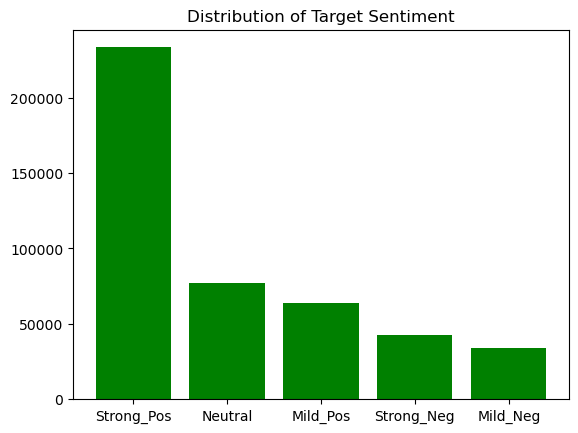

In [52]:
plt.bar(x=df.Sentiment.value_counts().index,height=df.Sentiment.value_counts().values,color='green')
plt.title('Distribution of Target Sentiment')
plt.show()

In [53]:
df['Sentiment'] = df.Sentiment.replace(to_replace = {'Mild_Pos':'Positive',
                                        'Mild_Neg':'Negative',
                                        'Strong_Pos':'Positive',
                                        'Strong_Neg':'Negative'})

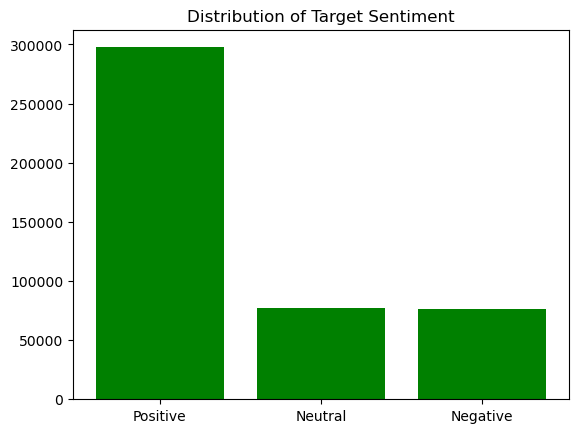

In [54]:
plt.bar(x=df.Sentiment.value_counts().index,height=df.Sentiment.value_counts().values,color='green')
plt.title('Distribution of Target Sentiment')
plt.show()

## Preprocessing

In [55]:
def removal_html(record):
    return re.sub(r'<.*?>','',record)
def removal_url(record):
    clean_text = re.sub(r'https?:\/\/[^\s]+','',record)
    return re.sub(r'www\.[a-z]?\.?(com)+|[a-z]*?\.?(com)+','',clean_text)
def twitter_handles(record):
    return re.sub(r'@\w*','',record)

In [56]:
def preprocess(record):
    record = twitter_handles(record)          # handling twitter handles
    record = removal_url(record)             # removal of urls and www sites
    record = removal_html(record)            # removal of html tags
    # handling punctuations
    record = re.sub(r"[^a-z\s\-:\\\/\];='#]", ' ', record)

    # removing hashtage but keep the data in it
    record = re.sub(r'#','',record)

    # removing numeric terms
    record = re.sub(r'[0-9]+','',record)

    # removing brackets
    record = re.sub(r'\[.*?\]|\(.*?\)','',record)

    # hanlding multiple spaces
    record = re.sub(r'\s+',' ',record)
    return record


In [57]:
df['CleanTweet'] = df.Tweet.apply(preprocess)

In [58]:
df.tail(2)

,Tweet,Sentiment,CleanTweet
451055,"gaza; peace n' freedom - ""israel stops aid con...",Positive,gaza; peace n' freedom - israel stops aid conv...
451056,@convoy 83 yes! get on freedom server!,Positive,yes get on freedom server


## Tokenizing

In [59]:
tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
df['tweet_tokens'] = [tokenizer.tokenize(item) for item in df.CleanTweet]


In [60]:
df.tail(9)

,Tweet,Sentiment,CleanTweet,tweet_tokens
451048,freedom convoy makes city stop: the army navy ...,Positive,freedom convoy makes city stop: the army navy ...,"[freedom, convoy, makes, city, stop, :, the, a..."
451049,next week: freedom snatch goes for 44- tying c...,Positive,next week: freedom snatch goes for - tying con...,"[next, week, :, freedom, snatch, goes, for, -,..."
451050,broll of a navy convoy crossing the kuwaiti/ir...,Positive,broll of a navy convoy crossing the kuwaiti/ir...,"[broll, of, a, navy, convoy, crossing, the, ku..."
451051,watch broll of a navy convoy crossing the kuwa...,Positive,watch broll of a navy convoy crossing the kuwa...,"[watch, broll, of, a, navy, convoy, crossing, ..."
451052,gaza; peace n' freedom - viva palestina convoy...,Positive,gaza; peace n' freedom - viva palestina convoy...,"[gaza, ;, peace, n, ', freedom, -, viva, pales..."
451053,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, of, defense, :, soldier, finds, freedom..."
451054,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, of, defense, :, soldier, finds, freedom..."
451055,"gaza; peace n' freedom - ""israel stops aid con...",Positive,gaza; peace n' freedom - israel stops aid conv...,"[gaza, ;, peace, n, ', freedom, -, israel, sto..."
451056,@convoy 83 yes! get on freedom server!,Positive,yes get on freedom server,"[yes, get, on, freedom, server]"


## Handling Slang/Abbreviations

In [61]:
import json
with open('abbreviation_dict.json', 'r', encoding='utf-8') as f:
    abbreviation_dict = json.load(f)
len(abbreviation_dict)


102

In [62]:
def replace_slang(tokens):

    new_token = []
    for token in tokens:
        if token in abbreviation_dict.keys():
            replacement = abbreviation_dict[token].lower().replace(',','').split(' ')
            new_token.extend(replacement)
        else:
            new_token.append(token)
    return new_token
df.tweet_tokens = df['tweet_tokens'].apply(replace_slang)

## Replace emoticons with words

In [63]:
import json
with open('emoticons.json', 'r', encoding='utf-8') as f:
    emoticons_dict = json.load(f)

In [64]:
def convert_emoticons(tokens):
    new_token = []
    for token in tokens:
        if token in emoticons_dict.keys():
            replacement = emoticons_dict[token].lower().replace(',','').split(' ')
            new_token.extend(replacement)
        else:
            new_token.append(token)
    return new_token
df.tweet_tokens = df.tweet_tokens.apply(convert_emoticons)

In [65]:
df

,Tweet,Sentiment,CleanTweet,tweet_tokens
0,@_angelica_toy happy anniversary!!!....the day...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, the, day, the, freedumb, ..."
1,@mcfarlaneglenda happy anniversary!!!....the d...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, the, day, the, freedumb, ..."
2,@thevivafrei @justintrudeau happy anniversary!...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, the, day, the, freedumb, ..."
3,@nchartieret happy anniversary!!!....the day t...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, the, day, the, freedumb, ..."
4,@tabithapeters05 happy anniversary!!!....the d...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, the, day, the, freedumb, ..."
...,...,...,...,...
451052,gaza; peace n' freedom - viva palestina convoy...,Positive,gaza; peace n' freedom - viva palestina convoy...,"[gaza, ;, peace, and, ', freedom, -, viva, pal..."
451053,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, of, defense, :, soldier, finds, freedom..."
451054,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, of, defense, :, soldier, finds, freedom..."
451055,"gaza; peace n' freedom - ""israel stops aid con...",Positive,gaza; peace n' freedom - israel stops aid conv...,"[gaza, ;, peace, and, ', freedom, -, israel, s..."


## Replace emoji with words

In [66]:
def contains_emoji(token):
    if any(emoji.is_emoji(t) for t in token):
        print(token)

df.tweet_tokens.apply(contains_emoji)

0         None
1         None
2         None
3         None
4         None
          ... 
451052    None
451053    None
451054    None
451055    None
451056    None
Name: tweet_tokens, Length: 451057, dtype: object

In [67]:
## There are no emoji's in the tweets

## Removing stopwords and further punctuation handling

In [68]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_tokens(token):
    return [word for word in token if word not in stop_words and word not in punctuation]

df.tweet_tokens = df.tweet_tokens.apply(clean_tokens)

In [69]:
df

,Tweet,Sentiment,CleanTweet,tweet_tokens
0,@_angelica_toy happy anniversary!!!....the day...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, day, freedumb, died, tune..."
1,@mcfarlaneglenda happy anniversary!!!....the d...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, day, freedumb, died, tune..."
2,@thevivafrei @justintrudeau happy anniversary!...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, day, freedumb, died, tune..."
3,@nchartieret happy anniversary!!!....the day t...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, day, freedumb, died, tune..."
4,@tabithapeters05 happy anniversary!!!....the d...,Positive,happy anniversary the day the freedumb died i...,"[happy, anniversary, day, freedumb, died, tune..."
...,...,...,...,...
451052,gaza; peace n' freedom - viva palestina convoy...,Positive,gaza; peace n' freedom - viva palestina convoy...,"[gaza, peace, freedom, viva, palestina, convoy..."
451053,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, defense, soldier, finds, freedom, fight..."
451054,face of defense: soldier finds freedom in u.s....,Positive,face of defense: soldier finds freedom in u s ...,"[face, defense, soldier, finds, freedom, fight..."
451055,"gaza; peace n' freedom - ""israel stops aid con...",Positive,gaza; peace n' freedom - israel stops aid conv...,"[gaza, peace, freedom, israel, stops, aid, con..."


## Lemmatization

In [70]:
def vocab(column):
    vocabulary = set(token for record in column for token in record)
    return vocabulary
# this gets all tokens in the data


In [71]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
df['lemmatized'] = df['tweet_tokens'].apply(lemmatize_tokens)

vocab1 = list(vocab(df.tweet_tokens))
vocab2 = list(vocab(df.lemmatized))

print('Number of tokens in original tweets ',len(vocab1))
print('Number of tokens in lemmatized tweets ',len(vocab2))

Number of tokens in original tweets  138870
Number of tokens in lemmatized tweets  132225


## Feature Engineering & Model Building

In [72]:
print(f'The vocabulary of our data after lemmatization has {len(vocab2)} tokens')

The vocabulary of our data after lemmatization has 132225 tokens


In [73]:
def evaluate_model(y_test, y_pred, model_name):
    metrics = {}
    
    metrics['Model'] = model_name
    metrics['Accuracy'] = accuracy_score(y_test, y_pred) * 100
    metrics['Precision'] = precision_score(y_test, y_pred, average='weighted') * 100
    metrics['Recall'] = recall_score(y_test, y_pred, average='weighted') * 100
    metrics['F1-Score (Weighted)'] = f1_score(y_test, y_pred, average='weighted') * 100
    f1_positive = f1_score(y_test, y_pred, average='macro', pos_label='Positive')
    f1_negative = f1_score(y_test, y_pred, average='macro', pos_label='Negative')
    # f1_positive = f1_score(y_test, y_pred, average='macro', labels=['Positive'], zero_division=0)  #
    # f1_negative = f1_score(y_test, y_pred, average='macro', labels=['Negative'], zero_division=0)
    metrics['F1-Score (Positive Class)'] = f1_positive 
    metrics['F1-Score (Negative Class)'] = f1_negative 

    # Classification report (optional, not necessary to include in the DataFrame)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return metrics


In [74]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

### 1. Count Vectorization & Unigram & SVC

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

temp = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))
vectorizer = CountVectorizer(ngram_range=(1, 1),max_features=10000)
count_matrix = vectorizer.fit_transform(temp)

count_matrix.shape 

(451057, 10000)

In [90]:
import pickle

with open('vectorizers/CountVectorizer_unigram.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(count_matrix, df['Sentiment'], test_size=0.4, random_state=100)


print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (270634, 10000)
Training set shape: (270634,)
Test set shape: (180423, 10000)
Test set shape: (180423,)


In [79]:
# Train the SVM model

model1 = LinearSVC()
# model1 = SVC(kernel='linear', probability=True)

model1.fit(X_train_scaled, y_train)

LinearSVC()

In [80]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score (Weighted)', 
                                   'F1-Score (Positive Class)', 'F1-Score (Negative Class)'])

model_names = ['Count Vectorizer (Unigram) SVC', 'TF-IDF (Unigram Bigram) SVC', 'OneHot Encoded (Unigram Bigram) SVC', 
                'OneHot Encoded (Unigram Bigram) Naive Bayes', 'Word2Vec CBOW SVC', 'Word2Vec Skipgram SVC','Glove SVC']


In [81]:
y_pred = model1.predict(X_test_scaled)
decision_scores = model1.decision_function(X_test_scaled)

metrics = evaluate_model(y_test, y_pred, model_names[0])


Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.61      0.65     30658
     Neutral       0.68      0.44      0.53     30893
    Positive       0.84      0.94      0.89    118872

    accuracy                           0.80    180423
   macro avg       0.74      0.66      0.69    180423
weighted avg       0.79      0.80      0.79    180423



In [82]:
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)

In [83]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.73129,0.690188,0.690188


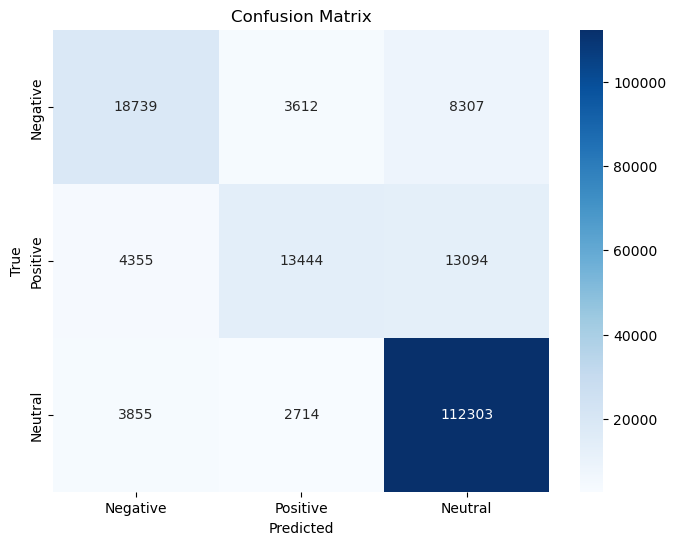

In [84]:
plot_confusion_matrix(y_test, y_pred)

In [92]:
import pickle
with open('models/Model_CountVec_Unigram.pkl', 'wb') as file:
    pickle.dump(model1, file)
    
print("Model has been saved.")

Model has been saved.


### 2. TFIDF Vectorization & Unigram, Bigram & SVC

In [93]:
temp = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)  # Unigrams and Bigrams, limited to 1000 features
tfidf_matrix = vectorizer.fit_transform(temp) 
tfidf_matrix.shape

(451057, 10000)

In [94]:
import pickle
with open('vectorizers/TFIDFVectorizer_UnigramBigram.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Sentiment'], test_size=0.4, random_state=100)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (270634, 10000)
Training set shape: (270634,)
Test set shape: (180423, 10000)
Test set shape: (180423,)


In [96]:
# Train the SVM model

model2 = LinearSVC()
model2.fit(X_train_scaled, y_train)

LinearSVC()

In [97]:
y_pred = model2.predict(X_test_scaled)
metrics = evaluate_model(y_test, y_pred, model_names[1])
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.63      0.66     30658
     Neutral       0.72      0.44      0.55     30893
    Positive       0.84      0.94      0.89    118872

    accuracy                           0.80    180423
   macro avg       0.75      0.67      0.70    180423
weighted avg       0.79      0.80      0.79    180423



In [98]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434


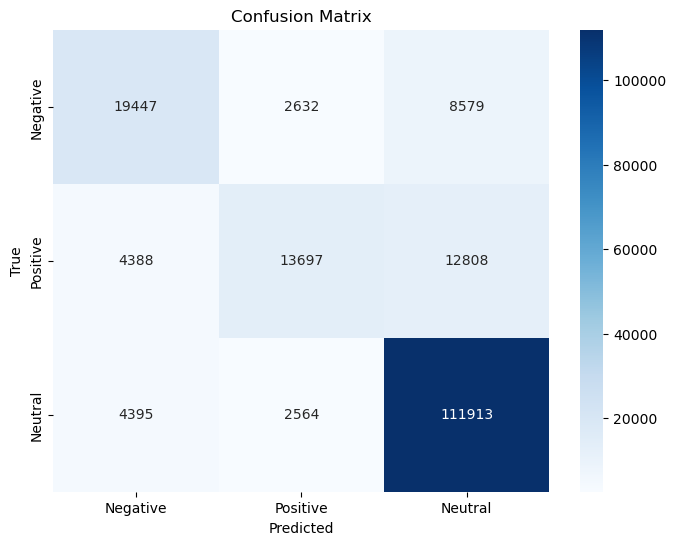

In [99]:
plot_confusion_matrix(y_test, y_pred)

In [100]:
import pickle
with open('models/Model_TFIDF_UnigramBigram.pkl', 'wb') as file:
    pickle.dump(model2, file)
    
print("Model has been saved.")

Model has been saved.


### 3. One Hot Encoding & Unigram, Bigram & SVC

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

temp = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))
vectorizer = CountVectorizer(binary=True,ngram_range=(1, 2),max_features = 10000)  # binary=True ensures one-hot encoding
onehot_matrix = vectorizer.fit_transform(temp)

onehot_matrix.shape # The shape of the encoded matrix is extremely huge. It has 120,182 features of 1's and 0's. Very sparse.
# So, we used a max feature of 10000.

(451057, 10000)

In [102]:
import pickle
with open('vectorizers/OneHot_UnigramBigram.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

The rows of the encoded matrix is the number of twet documents in out data<br>
The columns is the number of unique words in all of these documents. It is the vocabulary of our data.

In [103]:
# y=df['Sentiment'].unique()
X_train, X_test, y_train, y_test = train_test_split(onehot_matrix, df['Sentiment'], test_size=0.4, random_state=100)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)


scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (270634, 10000)
Training set shape: (270634,)
Test set shape: (180423, 10000)
Test set shape: (180423,)


In [104]:
# Train the SVM model

model3 = LinearSVC()
model3.fit(X_train_scaled, y_train)

LinearSVC()

In [105]:

y_pred = model3.predict(X_test_scaled)
metrics = evaluate_model(y_test, y_pred, model_names[2])
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.61      0.65     30658
     Neutral       0.69      0.48      0.57     30893
    Positive       0.85      0.94      0.89    118872

    accuracy                           0.80    180423
   macro avg       0.74      0.68      0.70    180423
weighted avg       0.79      0.80      0.79    180423



In [106]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434
2,OneHot Encoded (Unigram Bigram) SVC,80.456483,79.326845,80.456483,79.361554,0.701211,0.701211


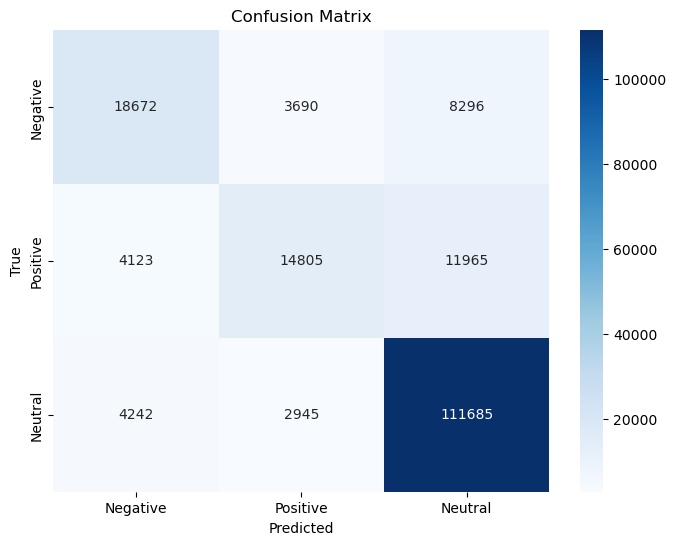

In [107]:
plot_confusion_matrix(y_test, y_pred)

In [108]:
import pickle
with open('models/Model_OneHot_UnigramBigram_SVC.pkl', 'wb') as file:
    pickle.dump(model3, file)
    
print("Model has been saved.")

Model has been saved.


### 4. One Hot Encoding & Unigram, Bigram & Naive bayes

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

temp = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))
vectorizer = CountVectorizer(binary=True,ngram_range=(1, 2),max_features = 10000)  # binary=True ensures one-hot encoding
onehot_matrix = vectorizer.fit_transform(temp)

onehot_matrix.shape # The shape of the encoded matrix is extremely huge. It has 120,182 features of 1's and 0's. Very sparse.
# So, we used a max feature of 10000.

(451057, 10000)

In [111]:
## vectorizer is the same as before

In [112]:
# y=df['Sentiment'].unique()
X_train, X_test, y_train, y_test = train_test_split(onehot_matrix, df['Sentiment'], test_size=0.4, random_state=100)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)


scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (270634, 10000)
Training set shape: (270634,)
Test set shape: (180423, 10000)
Test set shape: (180423,)


In [113]:
model4 = MultinomialNB()
model4.fit(X_train_scaled, y_train)

MultinomialNB()

In [114]:
y_pred = model4.predict(X_test_scaled)
metrics = evaluate_model(y_test, y_pred, model_names[3])
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.40      0.67      0.50     30658
     Neutral       0.42      0.49      0.46     30893
    Positive       0.87      0.68      0.76    118872

    accuracy                           0.64    180423
   macro avg       0.56      0.61      0.57    180423
weighted avg       0.71      0.64      0.66    180423



In [115]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434
2,OneHot Encoded (Unigram Bigram) SVC,80.456483,79.326845,80.456483,79.361554,0.701211,0.701211
3,OneHot Encoded (Unigram Bigram) Naive Bayes,64.438569,71.158555,64.438569,66.398184,0.571534,0.571534


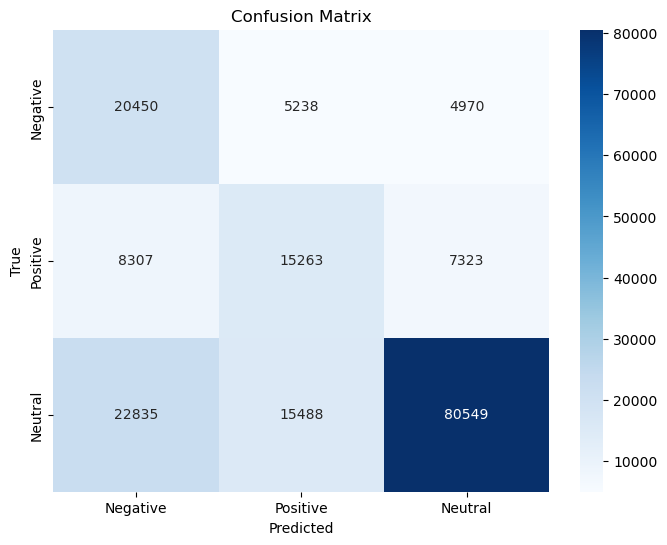

In [116]:
plot_confusion_matrix(y_test, y_pred)

In [117]:
import pickle
with open('models/Model_OneHot_UnigramBigram_NB.pkl', 'wb') as file:
    pickle.dump(model4, file)
    
print("Model has been saved.")

Model has been saved.


### 5. Word2Vec CBOW SVC

In [118]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random



In [119]:
model_word2vec_cbow = gensim.models.Word2Vec(sentences=df['lemmatized'], vector_size=300, window=5, sg=0)  # sg=0 for CBOW
model_word2vec_cbow.train(df['lemmatized'], total_examples= len(df['lemmatized']), epochs=20)


(101017799, 123760060)

In [120]:
model_word2vec_cbow.save("vectorizers/Word2Vec_CBOW.model")


In [124]:
  
def document_vector(words, model):
    # removing tokens not there in word2vec embedding
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X = np.array([document_vector(tweet,model_word2vec_cbow)  for tweet in df['lemmatized']])
y = df['Sentiment']


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)


Training set shape: (270634, 300)
Training set shape: (270634,)
Test set shape: (180423, 300)
Test set shape: (180423,)


In [126]:
# Train the SVM model
# Train the SVM model
model5 = LinearSVC()
model5.fit(X_train, y_train)


y_pred_cbow = model5.predict(X_test)
metrics = evaluate_model(y_test, y_pred_cbow, model_names[4])
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.63      0.37      0.47     30658
     Neutral       0.72      0.28      0.40     30893
    Positive       0.75      0.96      0.84    118872

    accuracy                           0.74    180423
   macro avg       0.70      0.53      0.57    180423
weighted avg       0.73      0.74      0.70    180423



In [127]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434
2,OneHot Encoded (Unigram Bigram) SVC,80.456483,79.326845,80.456483,79.361554,0.701211,0.701211
3,OneHot Encoded (Unigram Bigram) Naive Bayes,64.438569,71.158555,64.438569,66.398184,0.571534,0.571534
4,Word2Vec CBOW SVC,73.996109,72.829747,73.996109,70.309760,0.569643,0.569643


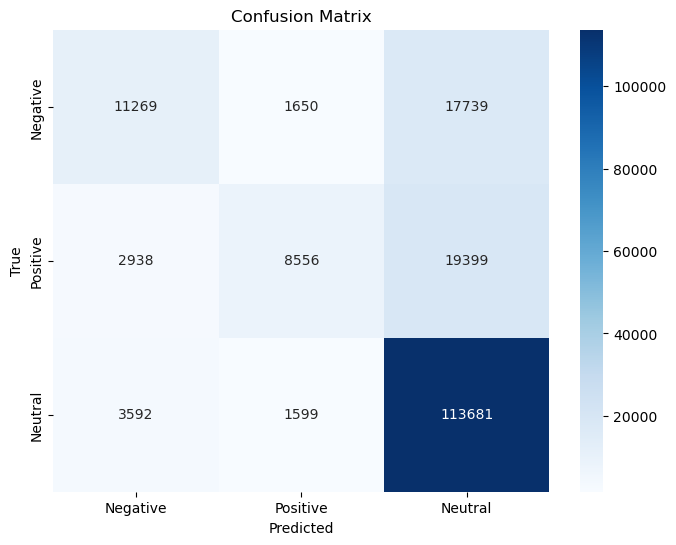

In [128]:
plot_confusion_matrix(y_test, y_pred_cbow)

In [129]:
import pickle
with open('models/Model_Word2Vec_CBOW.pkl', 'wb') as file:
    pickle.dump(model5, file)
    
print("Model has been saved.")

Model has been saved.


### 6. SVM Model - Word2Vec (Skipgram)

In [130]:
model_word2vec_skipgram = gensim.models.Word2Vec(sentences=df['lemmatized'], vector_size=300, window=5, sg=1)  # sg=1 is for skipgram
model_word2vec_skipgram.train(df['lemmatized'], total_examples= len(df['lemmatized']), epochs=20)

(101013210, 123760060)

In [132]:
model_word2vec_skipgram.save("vectorizers/Word2Vec_Skipgram.model")


#### Averaging word vectors for tweets

In [133]:
X = np.array([document_vector(tweet,model_word2vec_skipgram)  for tweet in df['lemmatized']])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)

print("Test set shape:", X_test.shape)
print("Test set shape:", y_test.shape)


Training set shape: (270634, 300)
Training set shape: (270634,)
Test set shape: (180423, 300)
Test set shape: (180423,)


In [134]:
# Train the SVM model
model6 = LinearSVC()
model6.fit(X_train, y_train)

y_pred_skip = model6.predict(X_test)

metrics = evaluate_model(y_test, y_pred_skip, model_names[5])
results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.61      0.31      0.41     30658
     Neutral       0.71      0.27      0.39     30893
    Positive       0.74      0.96      0.84    118872

    accuracy                           0.73    180423
   macro avg       0.69      0.51      0.55    180423
weighted avg       0.72      0.73      0.69    180423



In [135]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434
2,OneHot Encoded (Unigram Bigram) SVC,80.456483,79.326845,80.456483,79.361554,0.701211,0.701211
3,OneHot Encoded (Unigram Bigram) Naive Bayes,64.438569,71.158555,64.438569,66.398184,0.571534,0.571534
4,Word2Vec CBOW SVC,73.996109,72.829747,73.996109,70.309760,0.569643,0.569643
5,Word2Vec Skipgram SVC,72.997345,71.575684,72.997345,68.864813,0.547330,0.547330


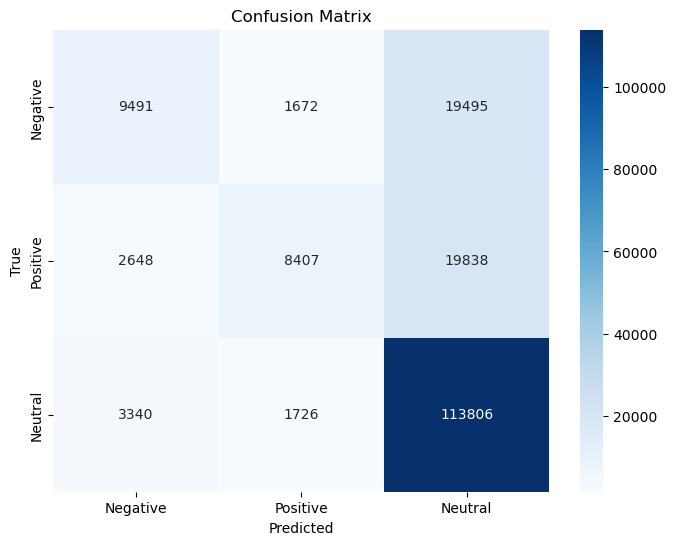

In [136]:
plot_confusion_matrix(y_test, y_pred_skip)

In [138]:
import pickle
with open('models/Model_Word2Vec_SKIPGRAM.pkl', 'wb') as file:
    pickle.dump(model6, file)
    
print("Model has been saved.")

Model has been saved.


## Summary

In [139]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score (Weighted),F1-Score (Positive Class),F1-Score (Negative Class)
0,Count Vectorizer (Unigram) SVC,80.081808,78.798694,80.081808,78.731290,0.690188,0.690188
1,TF-IDF (Unigram Bigram) SVC,80.398286,79.433437,80.398286,79.123578,0.699434,0.699434
2,OneHot Encoded (Unigram Bigram) SVC,80.456483,79.326845,80.456483,79.361554,0.701211,0.701211
3,OneHot Encoded (Unigram Bigram) Naive Bayes,64.438569,71.158555,64.438569,66.398184,0.571534,0.571534
4,Word2Vec CBOW SVC,73.996109,72.829747,73.996109,70.309760,0.569643,0.569643
5,Word2Vec Skipgram SVC,72.997345,71.575684,72.997345,68.864813,0.547330,0.547330


In [140]:
# results_df.to_csv('Model_Summary.csv',index = False)


* Count Vectorizer (Unigram) SVC:<br>The Count Vectorizer (Unigram) SVC model achieved an accuracy of 80.08%, indicating that it correctly classified 80% of the tweets. With a precision of 78.80%, it correctly predicted 78.80% of the positive tweets, while its recall of 80.08% shows it identified 80.08% of all actual positives. The weighted F1-score of 78.73% demonstrates a good balance between precision and recall, with positive and negative classes both achieving an F1-score of 0.69, indicating consistent performance for both classes.

* TF-IDF (Unigram Bigram) SVC:<br>The TF-IDF (Unigram Bigram) SVC model slightly outperformed the Count Vectorizer, achieving an accuracy of 80.40%. It had a precision of 79.43%, which means it correctly predicted 79.43% of positive tweets, and a recall of 80.40%, indicating it identified 80.40% of all positive tweets. Its weighted F1-score of 79.12% reflects a strong balance between precision and recall, while both the positive and negative classes achieved F1-scores of 0.70, showing improved performance over the previous model.


* OneHot Encoded (Unigram Bigram) SVC:<br>The OneHot Encoded (Unigram Bigram) SVC model had the highest performance, with an accuracy of 80.46%. It achieved a precision of 79.33% and a recall of 80.46%, indicating that it effectively identified positive instances and minimized false positives. The weighted F1-score of 79.36% was the highest among the models, demonstrating an excellent balance between precision and recall. The F1-scores for both positive and negative classes were slightly better compared to other models, indicating consistent and reliable performance across classes.


* OneHot Encoded (Unigram Bigram) Naive Bayes:<br>The OneHot Encoded (Unigram Bigram) Naive Bayes model had a significantly lower performance, achieving an accuracy of only 64.44%. Its precision was 71.16%, meaning it correctly predicted 71.16% of positive tweets, while the recall of 64.44% indicates it struggled to identify many actual positives. The weighted F1-score of 66.40% reflects its weaker balance between precision and recall, with both positive and negative classes having F1-scores below 0.6, indicating inconsistency in correctly classifying both classes.


* Word2Vec CBOW SVC:<br>The Word2Vec CBOW SVC model performed moderately well, with an accuracy of 73.94%. It achieved a precision of 72.82%, indicating its positive predictions were mostly correct, and a recall of 73.94%, meaning it identified a decent proportion of actual positives. However, its weighted F1-score of 70.22% was lower compared to the top models, indicating a weaker balance between precision and recall. The F1-scores for both positive and negative classes were around 0.57, showing a drop in its ability to effectively classify both classes.


* Word2Vec Skipgram SVC:<br>The Word2Vec Skipgram SVC model had similar results to the CBOW version, with an accuracy of 72.90%. It had a precision of 71.45%, meaning its positive predictions were not as reliable compared to other vectorization methods, and a recall of 72.90%, indicating its detection of actual positives was also lower. The weighted F1-score of 68.72% suggests a weak balance between precision and recall, with both positive and negative classes having F1-scores of approximately 0.55, highlighting a lower overall performance compared to the top models.

Summary: <br>The SVC models with TF-IDF, Count Vectorizer, and OneHot Encoded features performed the best, achieving around 80% accuracy, while Word2Vec models had lower performance. The Naive Bayes model performed significantly worse. The OneHot Encoded (Unigram Bigram) SVC gave the highest overall weighted F1-score (79.36%).